# Predicting Fish Mercury

Research Question: Does the geochemistry affect mercury (hg) in fish?

Data csv for soil geochemistry: https://mrdata.usgs.gov/geochem/ and metadata avaliable from: https://mrdata.usgs.gov/geochem/about.php

Data csv for fish Hg: https://www.epa.gov/fish-tech/national-survey-mercury-concentrations-fish-database-1990-1995

### Setup & Imports

In [1]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold

# Spatial imports
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
import geopandas as gpd
import geopandas as sjoin 
import rasterio
from rasterio import features
from rasterio.plot import show

# Model imports
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(565)

### Load and prepare the data

In [120]:
# Load the national geochem data
ngs_df = pd.read_csv('/Users/kristineccles/Code/geochem_hg/geochem.csv')
ngs_df.describe()

/Users/kristineccles/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LATITUDE,LONGITUDE,AL_ICP40,CA_ICP40,FE_ICP40,K_ICP40,MG_ICP40,NA_ICP40,P_ICP40,TI_ICP40,...,NI_ICP40,PB_ICP40,SN_ICP40,SR_ICP40,TH_ICP40,V_ICP40,ZN_ICP40,AS_AA,SE_AA,HG_AA
count,64756.000000,64756.000000,66926.00000,66926.000000,66926.000000,66926.000000,66914.000000,66926.00000,66882.000000,66926.000000,...,66926.000000,66926.000000,65760.000000,66917.000000,66926.000000,66924.000000,66922.000000,54323.000000,48060.000000,48447.000000
mean,38.919475,-100.767991,5.16163,2.123467,2.774039,1.540339,0.781945,1.02272,0.065974,0.393615,...,23.216215,47.672904,2.815328,204.906236,13.180214,80.430972,88.443083,8.013712,0.332393,0.062845
std,5.237618,14.662913,2.37358,2.762815,2.021084,0.791471,0.783797,0.77432,0.075569,0.251315,...,79.206982,269.649241,14.769954,186.031534,24.514914,62.902319,230.604712,30.259474,1.206232,1.075024
min,24.754440,-124.603550,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.429575,-115.567625,3.64700,0.490000,1.650000,1.050000,0.302000,0.38000,0.032250,0.246000,...,10.000000,13.000000,0.000000,80.000000,7.000000,44.000000,38.000000,2.800000,0.000000,0.000000
50%,39.529450,-101.821850,5.49600,1.380000,2.490000,1.630000,0.610000,0.91300,0.060000,0.324000,...,17.000000,18.000000,0.000000,159.000000,10.000000,70.000000,63.000000,5.200000,0.200000,0.030000
75%,42.882925,-87.819900,6.97475,2.750000,3.400000,2.040000,1.029000,1.55000,0.081000,0.479000,...,26.000000,25.000000,0.000000,298.000000,14.000000,100.000000,85.000000,8.600000,0.400000,0.040000
max,49.340430,-66.984800,16.99000,38.020000,64.400000,17.000000,20.700000,8.40000,9.000000,9.595000,...,15800.000000,33410.000000,743.000000,7500.000000,1180.000000,3440.000000,27040.000000,4910.000000,223.000000,199.000000


In [3]:
# creating a geometry column 
ngs_xy = [Point(xy) for xy in zip(ngs_df['LONGITUDE'], ngs_df['LATITUDE'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
ngs_gdf = gpd.GeoDataFrame(ngs_df, crs=crs, geometry=ngs_xy)

# Write to shapefile
#ngs_gdf.to_file("ngs_gdf.shp")

# Look at the data
ngs_gdf.head()


,REC_NO,DATASET,CONTAMSOU,CONTAMPOT,CONTAMDEGR,LATITUDE,LONGITUDE,AL_ICP40,CA_ICP40,FE_ICP40,...,PB_ICP40,SN_ICP40,SR_ICP40,TH_ICP40,V_ICP40,ZN_ICP40,AS_AA,SE_AA,HG_AA,geometry
0,5271138,NURE2000NE,none,NaN,NaN,44.8100,-66.9848,9.164,1.540,6.73,...,111.0,0.0,145.0,10,197.0,136.0,14.9,0.4,0.12,POINT (-66.98480 44.81000)
1,5271119,NURE2000NE,none,NaN,NaN,44.7756,-67.0307,7.413,0.960,3.54,...,28.0,0.0,93.0,7,117.0,31.0,7.6,2.1,0.14,POINT (-67.03070 44.77560)
2,5271123,NURE2000NE,none,NaN,NaN,44.8199,-67.0526,5.927,0.989,2.68,...,122.0,0.0,99.0,7,82.0,78.0,12.3,0.2,0.03,POINT (-67.05260 44.81990)
3,5271106,NURE2000NE,none,NaN,NaN,44.9324,-67.0757,6.169,0.405,3.55,...,33.0,0.0,65.0,13,96.0,68.0,13.9,0.9,0.08,POINT (-67.07570 44.93240)
4,5271121,NURE2000NE,none,NaN,NaN,44.7579,-67.0922,5.996,0.770,4.14,...,57.0,0.0,76.0,14,117.0,101.0,19.0,1.5,0.15,POINT (-67.09220 44.75790)


In [4]:
ngs_gdf.isnull().sum()

REC_NO            0
DATASET           0
CONTAMSOU     12165
CONTAMPOT     49747
CONTAMDEGR    65146
LATITUDE       2170
LONGITUDE      2170
AL_ICP40          0
CA_ICP40          0
FE_ICP40          0
K_ICP40           0
MG_ICP40         12
NA_ICP40          0
P_ICP40          44
TI_ICP40          0
AG_ICP40          0
AU_ICP40        234
BA_ICP40          2
BE_ICP40          0
CD_ICP40          0
CE_ICP40          0
CO_ICP40          0
CR_ICP40          0
CU_ICP40          0
GA_ICP40          0
LI_ICP40          0
MN_ICP40          7
MO_ICP40          0
NI_ICP40          0
PB_ICP40          0
SN_ICP40       1166
SR_ICP40          9
TH_ICP40          0
V_ICP40           2
ZN_ICP40          4
AS_AA         12603
SE_AA         18866
HG_AA         18479
geometry          0
dtype: int64

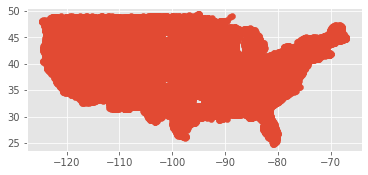

In [5]:
ngs_gdf.plot();

In [6]:
# Load the spatial data
hg_df = pd.read_csv('/Users/kristineccles/Code/geochem_hg/hgdata.csv')
hg_df.describe()

,LATITUDE,LONGITUDE,NUMBER_IN_,MEAN_LENGT,TOTAL_LENG,MEAN_WEIGH,TOTAL_WEIG,HG_CONCENT,FILLET_CON,DRY_WET_CO,WET_FILLET
count,19705.000000,19705.000000,15693.000000,5672.000000,10666.000000,12009.000000,10828.000000,19705.000000,1667.000000,173.000000,19705.000000
mean,38.898316,-87.010153,2.792583,482.968991,394.426920,1217.885549,1087.219164,0.397467,0.251363,0.126225,0.399501
std,6.838405,9.144062,4.866402,1626.257703,178.670984,6930.403179,9647.190470,0.431280,0.340589,0.210004,0.425481
min,25.106560,-124.308330,1.000000,0.000000,7.000000,0.000000,1.000000,0.001000,0.001400,0.006450,0.001000
25%,33.606110,-92.568900,1.000000,269.240000,288.000000,443.300000,275.000000,0.120000,0.085710,0.021500,0.128570
50%,39.538330,-89.000830,1.000000,369.000000,381.000000,777.300000,607.912000,0.260000,0.157140,0.043000,0.270000
75%,45.213840,-80.241390,4.000000,467.360000,485.785000,1315.440000,1100.000000,0.510000,0.314280,0.107500,0.520000
max,49.610300,-67.175000,225.000000,44958.000000,5770.000000,435448.704000,693996.372000,8.000000,8.571430,1.631850,8.571430


In [7]:

# creating a geometry column 
hg_xy = [Point(xy) for xy in zip(hg_df['LONGITUDE'], hg_df['LATITUDE'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
hg_gdf = gpd.GeoDataFrame(hg_df, crs=crs, geometry=hg_xy)

# Write to shapefile
#hg_gdf.to_file("hg_gdf.shp")

# Look at the Data
hg_gdf.head()

,Genus,Species,Tissue,LATITUDE,LONGITUDE,DATE,SAMPLE_TYP,NUMBER_IN_,MEAN_LENGT,TOTAL_LENG,MEAN_WEIGH,TOTAL_WEIG,MERCURY_BA,HG_CONCENT,FILLET_CON,DRY_WET_CO,WET_FILLET,geometry
0,Salmo,salar,Whole body,45.11056,-67.17500,1993-05-01,Composite,2.0,374.0,NaN,460.0,NaN,Wet,0.380,0.54285,NaN,0.54285,POINT (-67.17500 45.11056)
1,Salmo,salar,"Fillet, skin off",45.11056,-67.17500,1993-05-01,Composite,3.0,393.0,NaN,558.0,NaN,Wet,0.350,NaN,NaN,0.35000,POINT (-67.17500 45.11056)
2,Catostomus,commersoni,Whole body,45.11056,-67.17500,1993-05-01,Composite,5.0,423.0,NaN,778.0,NaN,Wet,0.074,0.10571,NaN,0.10571,POINT (-67.17500 45.11056)
3,Esox,niger,"Fillet, skin off",44.76889,-67.24889,1993-06-01,Composite,5.0,459.0,NaN,547.0,NaN,Wet,0.860,NaN,NaN,0.86000,POINT (-67.24889 44.76889)
4,Esox,niger,Whole body,44.76889,-67.24889,1993-06-01,Composite,5.0,367.0,NaN,259.0,NaN,Wet,0.520,0.74285,NaN,0.74285,POINT (-67.24889 44.76889)


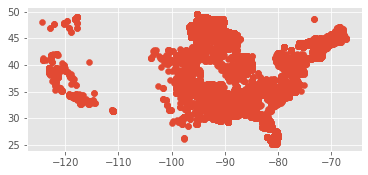

In [8]:
hg_gdf.plot();

In [9]:
# Create grid to aggregate all data to

x = ngs_df.LONGITUDE
y = ngs_df.LATITUDE

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

## Create a  Grid
lenght = 1
wide = 1

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide)) 
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), lenght)) 
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-lenght), (x, y-lenght)]) )

crs = {'init': 'epsg:4326'}

grid = gpd.GeoDataFrame({'geometry':polygons}, crs=crs)
grid.to_file("grid.shp")

#Create Index 
grid['id'] = grid.index
grid.head()

,geometry,id
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0
1,"POLYGON ((-125.00000 48.00000, -124.00000 48.0...",1
2,"POLYGON ((-125.00000 47.00000, -124.00000 47.0...",2
3,"POLYGON ((-125.00000 46.00000, -124.00000 46.0...",3
4,"POLYGON ((-125.00000 45.00000, -124.00000 45.0...",4


In [10]:
grid.shape

(1534, 2)

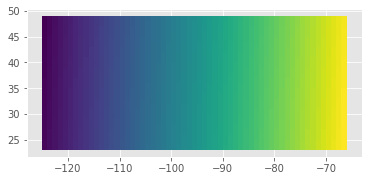

In [11]:
# Create a column to print out
grid.plot(column = 'id', );

In [12]:
# Create aggregrate data to grid with a spatial join
#Hg
hg_PointInPoly = gpd.sjoin(grid,hg_gdf, how='left')
avg_hg = hg_PointInPoly.groupby('id')['FILLET_CON'].agg(['mean'])
count_hg = hg_PointInPoly.groupby('id')['FILLET_CON'].agg(['count'])

hg_PointInPoly.head()

,geometry,id,index_right,Genus,Species,Tissue,LATITUDE,LONGITUDE,DATE,SAMPLE_TYP,NUMBER_IN_,MEAN_LENGT,TOTAL_LENG,MEAN_WEIGH,TOTAL_WEIG,MERCURY_BA,HG_CONCENT,FILLET_CON,DRY_WET_CO,WET_FILLET
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,19704.0,Prosopium,williamsoni,"Fillet, skin unknown",48.05722,-124.30833,1994-09-07,Composite,5.0,348.0,NaN,NaN,NaN,Wet,0.03,NaN,NaN,0.03
1,"POLYGON ((-125.00000 48.00000, -124.00000 48.0...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((-125.00000 47.00000, -124.00000 47.0...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((-125.00000 46.00000, -124.00000 46.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-125.00000 45.00000, -124.00000 45.0...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# NGS
list(ngs_gdf.columns) 

['REC_NO',
 'DATASET',
 'CONTAMSOU',
 'CONTAMPOT',
 'CONTAMDEGR',
 'LATITUDE',
 'LONGITUDE',
 'AL_ICP40',
 'CA_ICP40',
 'FE_ICP40',
 'K_ICP40',
 'MG_ICP40',
 'NA_ICP40',
 'P_ICP40',
 'TI_ICP40',
 'AG_ICP40',
 'AU_ICP40',
 'BA_ICP40',
 'BE_ICP40',
 'CD_ICP40',
 'CE_ICP40',
 'CO_ICP40',
 'CR_ICP40',
 'CU_ICP40',
 'GA_ICP40',
 'LI_ICP40',
 'MN_ICP40',
 'MO_ICP40',
 'NI_ICP40',
 'PB_ICP40',
 'SN_ICP40',
 'SR_ICP40',
 'TH_ICP40',
 'V_ICP40',
 'ZN_ICP40',
 'AS_AA',
 'SE_AA',
 'HG_AA',
 'geometry']

In [14]:
#NGS
ngs_PointInPoly = gpd.sjoin(grid, ngs_gdf, how='left')

avg_ngs = ngs_PointInPoly.groupby('id')[
 'AL_ICP40',
 'CA_ICP40',
 'FE_ICP40',
 'K_ICP40',
 'MG_ICP40',
 'NA_ICP40',
 'P_ICP40',
 'TI_ICP40',
 'AG_ICP40',
 'AU_ICP40',
 'BA_ICP40',
 'BE_ICP40',
 'CD_ICP40',
 'CE_ICP40',
 'CO_ICP40',
 'CR_ICP40',
 'CU_ICP40',
 'GA_ICP40',
 'LI_ICP40',
 'MN_ICP40',
 'MO_ICP40',
 'NI_ICP40',
 'PB_ICP40',
 'SN_ICP40',
 'SR_ICP40',
 'TH_ICP40',
 'V_ICP40',
 'ZN_ICP40',
 'AS_AA',
 'SE_AA',
 'HG_AA'].agg(['mean'])


ngs_PointInPoly.head()

/Users/kristineccles/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,geometry,id,index_right,REC_NO,DATASET,CONTAMSOU,CONTAMPOT,CONTAMDEGR,LATITUDE,LONGITUDE,...,NI_ICP40,PB_ICP40,SN_ICP40,SR_ICP40,TH_ICP40,V_ICP40,ZN_ICP40,AS_AA,SE_AA,HG_AA
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,64729.0,ST010685,States2004,none,not app,NaN,48.07975,-124.26762,...,37.0,7.0,0.0,83.0,0.0,144.0,73.0,10.4,1.5,0.23
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,64728.0,ST010685,States2004,none,not app,NaN,48.07975,-124.26762,...,38.0,8.0,0.0,85.0,0.0,142.0,72.0,9.6,1.4,0.22
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,64718.0,ST010666,States2004,none,not app,NaN,48.08743,-124.17407,...,50.0,5.0,0.0,189.0,0.0,229.0,91.0,5.9,0.3,0.05
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,64754.0,ST010708,States2004,none,not app,NaN,48.12727,-124.60355,...,21.0,6.0,0.0,125.0,0.0,110.0,68.0,6.6,0.5,0.07
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,64755.0,ST010708,States2004,none,not app,NaN,48.12727,-124.60355,...,22.0,7.0,0.0,127.0,0.0,112.0,73.0,7.3,0.5,0.07


In [15]:
# Join dataframes together
complete_df= pd.merge(left=grid, right=avg_hg, how='left', left_on='id', right_on='id')
#complete_df= pd.merge(left=complete_df, right=count_hg, how='left', left_on='id', right_on='id')
complete_df= pd.merge(left=complete_df, right=avg_ngs, how='left', left_on='id', right_on='id')
complete_df.head()

/Users/kristineccles/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,geometry,id,mean,"(AL_ICP40, mean)","(CA_ICP40, mean)","(FE_ICP40, mean)","(K_ICP40, mean)","(MG_ICP40, mean)","(NA_ICP40, mean)","(P_ICP40, mean)",...,"(NI_ICP40, mean)","(PB_ICP40, mean)","(SN_ICP40, mean)","(SR_ICP40, mean)","(TH_ICP40, mean)","(V_ICP40, mean)","(ZN_ICP40, mean)","(AS_AA, mean)","(SE_AA, mean)","(HG_AA, mean)"
0,"POLYGON ((-125.00000 49.00000, -124.00000 49.0...",0,NaN,7.068444,0.793111,4.554444,0.806667,1.044889,1.733111,0.081778,...,34.222222,6.111111,0.0,126.444444,0.000000,146.000000,75.777778,8.244444,0.933333,0.143333
1,"POLYGON ((-125.00000 48.00000, -124.00000 48.0...",1,NaN,7.224000,0.665571,4.487143,0.852143,0.826714,1.518929,0.100929,...,29.500000,8.928571,0.0,147.000000,2.071429,155.071429,68.000000,6.585714,1.342857,0.138571
2,"POLYGON ((-125.00000 47.00000, -124.00000 47.0...",2,NaN,7.010000,3.226000,4.820000,1.300000,2.046000,2.431000,0.074000,...,33.500000,9.500000,0.0,406.500000,9.000000,125.000000,75.000000,2.600000,0.000000,0.000000
3,"POLYGON ((-125.00000 46.00000, -124.00000 46.0...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((-125.00000 45.00000, -124.00000 45.0...",4,NaN,6.162000,1.948000,3.794000,1.250000,1.154600,1.601800,0.023200,...,41.400000,8.600000,0.0,305.000000,8.000000,67.600000,48.200000,3.300000,0.080000,0.008000


In [16]:
# clean up column names 
list(complete_df.columns) 

['geometry',
 'id',
 'mean',
 ('AL_ICP40', 'mean'),
 ('CA_ICP40', 'mean'),
 ('FE_ICP40', 'mean'),
 ('K_ICP40', 'mean'),
 ('MG_ICP40', 'mean'),
 ('NA_ICP40', 'mean'),
 ('P_ICP40', 'mean'),
 ('TI_ICP40', 'mean'),
 ('AG_ICP40', 'mean'),
 ('AU_ICP40', 'mean'),
 ('BA_ICP40', 'mean'),
 ('BE_ICP40', 'mean'),
 ('CD_ICP40', 'mean'),
 ('CE_ICP40', 'mean'),
 ('CO_ICP40', 'mean'),
 ('CR_ICP40', 'mean'),
 ('CU_ICP40', 'mean'),
 ('GA_ICP40', 'mean'),
 ('LI_ICP40', 'mean'),
 ('MN_ICP40', 'mean'),
 ('MO_ICP40', 'mean'),
 ('NI_ICP40', 'mean'),
 ('PB_ICP40', 'mean'),
 ('SN_ICP40', 'mean'),
 ('SR_ICP40', 'mean'),
 ('TH_ICP40', 'mean'),
 ('V_ICP40', 'mean'),
 ('ZN_ICP40', 'mean'),
 ('AS_AA', 'mean'),
 ('SE_AA', 'mean'),
 ('HG_AA', 'mean')]

In [17]:
complete_df.columns =['geometry',
 'id',
 'hg_mean',
 'AL_ICP40',
 'CA_ICP40',
 'FE_ICP40',
 'K_ICP40',
 'MG_ICP40',
 'NA_ICP40',
 'P_ICP40',
 'TI_ICP40',
 'AG_ICP40',
 'AU_ICP40',
 'BA_ICP40',
 'BE_ICP40',
 'CD_ICP40',
 'CE_ICP40',
 'CO_ICP40',
 'CR_ICP40',
 'CU_ICP40',
 'GA_ICP40',
 'LI_ICP40',
 'MN_ICP40',
 'MO_ICP40',
 'NI_ICP40',
 'PB_ICP40',
 'SN_ICP40',
 'SR_ICP40',
 'TH_ICP40',
 'V_ICP40',
 'ZN_ICP40',
 'AS_AA',                    
 'SE_AA',
 'HG_AA'] 

In [18]:
# Examine the dataset
complete_df.shape

(1534, 34)

In [19]:
complete_df.isnull().sum()

geometry       0
id             0
hg_mean     1314
AL_ICP40     635
CA_ICP40     635
FE_ICP40     635
K_ICP40      635
MG_ICP40     635
NA_ICP40     635
P_ICP40      635
TI_ICP40     635
AG_ICP40     635
AU_ICP40     635
BA_ICP40     635
BE_ICP40     635
CD_ICP40     635
CE_ICP40     635
CO_ICP40     635
CR_ICP40     635
CU_ICP40     635
GA_ICP40     635
LI_ICP40     635
MN_ICP40     635
MO_ICP40     635
NI_ICP40     635
PB_ICP40     635
SN_ICP40     635
SR_ICP40     635
TH_ICP40     635
V_ICP40      635
ZN_ICP40     635
AS_AA        635
SE_AA        636
HG_AA        635
dtype: int64

In [20]:
clean_df=complete_df.dropna()
clean_df.describe()

,id,hg_mean,AL_ICP40,CA_ICP40,FE_ICP40,K_ICP40,MG_ICP40,NA_ICP40,P_ICP40,TI_ICP40,...,NI_ICP40,PB_ICP40,SN_ICP40,SR_ICP40,TH_ICP40,V_ICP40,ZN_ICP40,AS_AA,SE_AA,HG_AA
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,...,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,848.073733,0.229449,4.543692,1.875061,2.389083,1.394084,0.666574,0.801160,0.051433,0.385447,...,21.084207,22.519702,4.359084,144.730265,12.958839,66.137048,59.182010,6.014135,0.284370,0.061797
std,351.891482,0.291052,1.675828,2.074639,1.032885,0.515440,0.562784,0.566967,0.025895,0.175025,...,28.246924,11.463912,10.206095,93.304633,13.336176,28.655073,33.636547,3.088472,0.215604,0.148313
min,8.000000,0.014280,0.278670,0.021185,0.108899,0.091129,0.015040,0.007881,0.006405,0.090771,...,0.321101,7.257143,0.000000,5.201613,0.571429,7.422018,4.211009,1.010092,0.000000,0.000000
25%,696.000000,0.088567,3.426544,0.666600,1.750000,1.016182,0.292352,0.344125,0.031077,0.264500,...,10.484848,16.171429,0.000000,74.893617,6.767442,47.091615,40.106383,3.750820,0.134375,0.012456
50%,838.000000,0.142850,4.555742,1.247513,2.210545,1.471250,0.559857,0.721830,0.050733,0.319963,...,16.305556,20.212121,0.000000,126.275362,9.978261,63.028571,54.375000,5.495714,0.233333,0.027742
75%,1103.000000,0.250186,5.515633,2.305690,2.879855,1.771011,0.803677,1.115788,0.068453,0.502875,...,23.125000,25.428571,0.780488,185.318182,13.657143,80.333333,72.137931,7.930435,0.361194,0.045714
max,1486.000000,2.923807,9.818377,14.675868,6.515333,2.373333,3.872000,2.413333,0.159461,1.055909,...,361.945455,110.654450,44.296296,496.281250,120.243902,157.400000,276.327273,19.197183,1.496000,1.338689


In [21]:
clean_df.shape

(217, 34)

In [22]:
clean_df.isnull().sum()

geometry    0
id          0
hg_mean     0
AL_ICP40    0
CA_ICP40    0
FE_ICP40    0
K_ICP40     0
MG_ICP40    0
NA_ICP40    0
P_ICP40     0
TI_ICP40    0
AG_ICP40    0
AU_ICP40    0
BA_ICP40    0
BE_ICP40    0
CD_ICP40    0
CE_ICP40    0
CO_ICP40    0
CR_ICP40    0
CU_ICP40    0
GA_ICP40    0
LI_ICP40    0
MN_ICP40    0
MO_ICP40    0
NI_ICP40    0
PB_ICP40    0
SN_ICP40    0
SR_ICP40    0
TH_ICP40    0
V_ICP40     0
ZN_ICP40    0
AS_AA       0
SE_AA       0
HG_AA       0
dtype: int64

# Assess relationships

In [23]:
# Removing the Id 
data = clean_df.iloc[:,2:]

In [24]:
data.head()

,hg_mean,AL_ICP40,CA_ICP40,FE_ICP40,K_ICP40,MG_ICP40,NA_ICP40,P_ICP40,TI_ICP40,AG_ICP40,...,NI_ICP40,PB_ICP40,SN_ICP40,SR_ICP40,TH_ICP40,V_ICP40,ZN_ICP40,AS_AA,SE_AA,HG_AA
8,0.089280,6.867500,0.781833,3.593333,1.140833,1.368333,1.688750,0.078750,0.317250,0.000000,...,67.500000,20.916667,0.000000,129.416667,1.250000,128.500000,101.166667,5.591667,0.175000,0.087500
36,0.366660,6.735958,0.809167,2.805417,1.471250,0.783333,1.425083,0.067125,0.339333,0.000000,...,64.125000,15.750000,0.000000,162.625000,3.000000,88.958333,76.375000,5.379167,0.095833,0.077500
53,0.128570,7.163773,1.842848,3.300000,0.828030,1.020470,1.957439,0.100076,0.475227,0.045455,...,50.757576,12.984848,0.000000,244.363636,1.500000,113.242424,67.924242,7.828788,0.172727,0.124697
59,0.321422,7.903836,2.191727,5.527636,1.016182,3.024036,1.305182,0.069909,0.434018,0.090909,...,361.945455,13.036364,0.418182,225.672727,5.163636,146.509091,92.672727,5.269091,0.212727,0.039636
62,0.180609,7.110580,1.005971,3.831884,1.367101,0.923319,1.504043,0.066841,0.438435,0.028986,...,110.246377,23.565217,0.000000,155.608696,4.028986,125.130435,95.289855,7.930435,0.153623,1.334783


In [25]:
corr = data.corr()

In [26]:
np.abs(data.corr()).sort_values(by='hg_mean', ascending=False).hg_mean

hg_mean     1.000000
SE_AA       0.237024
BA_ICP40    0.236150
K_ICP40     0.204060
CU_ICP40    0.198775
P_ICP40     0.197124
V_ICP40     0.196701
MO_ICP40    0.192106
FE_ICP40    0.183339
SR_ICP40    0.181774
CO_ICP40    0.176228
AL_ICP40    0.176135
ZN_ICP40    0.175506
GA_ICP40    0.172003
MG_ICP40    0.153953
LI_ICP40    0.142664
AS_AA       0.139282
MN_ICP40    0.123560
CA_ICP40    0.097141
CD_ICP40    0.090840
PB_ICP40    0.080162
CR_ICP40    0.072882
SN_ICP40    0.067933
NA_ICP40    0.066204
AU_ICP40    0.065837
NI_ICP40    0.046640
HG_AA       0.046040
TI_ICP40    0.040341
TH_ICP40    0.038638
AG_ICP40    0.027223
CE_ICP40    0.026162
BE_ICP40    0.004270
Name: hg_mean, dtype: float64

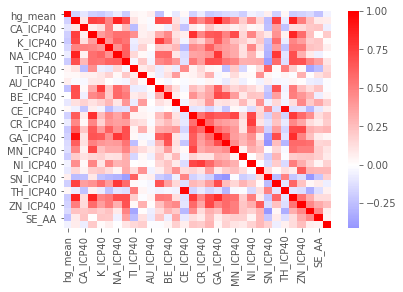

In [27]:
sns.heatmap(corr, cmap="bwr", center=0);

# Variable Selection

In [28]:
# compare the correlation between features and remove one of two features 
# that have a correlation higher than 0.7 to avoid multicolinearity
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]

data = data[selected_columns]

In [29]:
selected_columns = selected_columns[1:].values
selected_columns

array(['AL_ICP40', 'CA_ICP40', 'FE_ICP40', 'K_ICP40', 'MG_ICP40',
       'P_ICP40', 'TI_ICP40', 'AG_ICP40', 'AU_ICP40', 'BA_ICP40',
       'BE_ICP40', 'CD_ICP40', 'CE_ICP40', 'CR_ICP40', 'CU_ICP40',
       'LI_ICP40', 'MN_ICP40', 'MO_ICP40', 'NI_ICP40', 'PB_ICP40',
       'SN_ICP40', 'SR_ICP40', 'ZN_ICP40', 'AS_AA', 'SE_AA', 'HG_AA'],
      dtype=object)

In [30]:
# backwards stepwise variable elimiation

import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.20
data_modeled, selected_columns = backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)

In [31]:
# create new dataframe with selected variables

result = pd.DataFrame()

result['hg_mean'] = data.iloc[:,0]

In [32]:
X = pd.DataFrame(data = data_modeled, columns = selected_columns)

In [33]:
X.head()

,AL_ICP40,CA_ICP40,FE_ICP40,TI_ICP40,SR_ICP40,AS_AA,SE_AA
0,6.867500,0.781833,3.593333,0.317250,129.416667,5.591667,0.175000
1,6.735958,0.809167,2.805417,0.339333,162.625000,5.379167,0.095833
2,7.163773,1.842848,3.300000,0.475227,244.363636,7.828788,0.172727
3,7.903836,2.191727,5.527636,0.434018,225.672727,5.269091,0.212727
4,7.110580,1.005971,3.831884,0.438435,155.608696,7.930435,0.153623


## Scrub the data

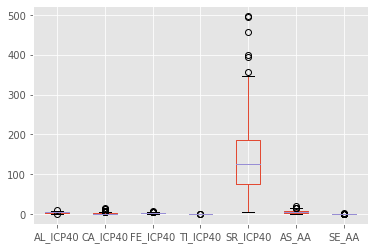

In [34]:
pd.plotting.boxplot(X);
# need to normalize data

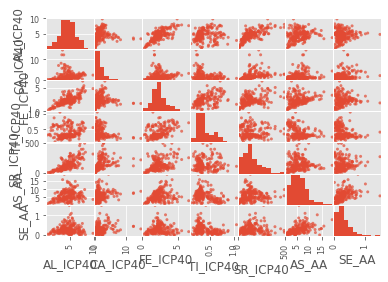

In [35]:
pd.plotting.scatter_matrix(X,alpha=0.7);

In [36]:
y = clean_df.iloc[:, 2]
y.head()

8     0.089280
36    0.366660
53    0.128570
59    0.321422
62    0.180609
Name: hg_mean, dtype: float64

In [37]:
X.shape

(217, 7)

In [38]:
X.head()

,AL_ICP40,CA_ICP40,FE_ICP40,TI_ICP40,SR_ICP40,AS_AA,SE_AA
0,6.867500,0.781833,3.593333,0.317250,129.416667,5.591667,0.175000
1,6.735958,0.809167,2.805417,0.339333,162.625000,5.379167,0.095833
2,7.163773,1.842848,3.300000,0.475227,244.363636,7.828788,0.172727
3,7.903836,2.191727,5.527636,0.434018,225.672727,5.269091,0.212727
4,7.110580,1.005971,3.831884,0.438435,155.608696,7.930435,0.153623


In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Train with {X_train.shape[0]} samples and test with {X_test.shape[0]} samples.")

Train with 173 samples and test with 44 samples.


In [40]:
# normalize data- this is a more approporate methods for toxicologoical data

# normalize the training set only
normalizer = MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)

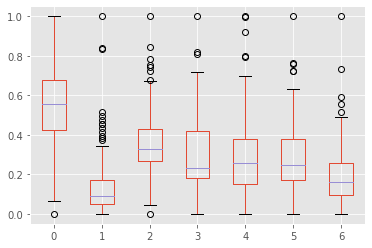

In [41]:
pd.plotting.boxplot(pd.DataFrame(X_train_norm));

In [42]:
# Must also scale the test input
X_test_norm = normalizer.transform(X_test)

### Create Model

In [43]:
# Since we are tuning the hyperparameters we need a validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train_norm, y_train, test_size=0.2)
X_train_val.shape

(138, 7)

In [44]:
models = []
for Model in tqdm([LinearRegression, Lasso, Ridge]):
    model = Model()
    model.fit(X_train_val, y_train_val)
    models.append(model)

100%|██████████| 3/3 [00:00<00:00, 603.15it/s]


In [45]:
# Evaluate the models with RMSE
def root_mean_squared_error(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [46]:
# Make validation predictions
metric = [root_mean_squared_error, mean_absolute_error][1]
val_losses = []
for model in models:
    y_hat = model.predict(X_val)
    val_losses.append(metric(y_val, y_hat))
val_losses


[0.1667953598247247, 0.15801332162930046, 0.1651968262188519]

# Tune the Model

In [47]:
# Create hyperparameter options
hyperparameters = {'alpha': np.linspace(0, 1, 10)}
hyperparameters

{'alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])}

In [48]:
hyperparameters = {'alpha': np.linspace(0, 1, 10)}
hyperparameters

tuner = GridSearchCV(Ridge(), hyperparameters, cv=5, verbose=True)
tuner

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [49]:
# Includes cross validation so don't need our validation set anymore
best_model = tuner.fit(X_train_norm, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
/Users/kristineccles/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
best_alpha = best_model.best_estimator_.get_params()['alpha']
print(f"Best alpha is {best_alpha:.3f}")

Best alpha is 1.000


In [51]:
# Retrain on full training set
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_norm, y_train)
models.append(best_model)

In [52]:
# Final test on the test set
test_losses = []
for model in models:
    y_hat = model.predict(X_test_norm)
    test_losses.append(metric(y_test, y_hat))
test_losses

[0.16355344751361012,
 0.13510666649380043,
 0.16019638554012033,
 0.14587969856540509]

## Present the model

In [53]:
print("Our model coefficients are:")
for param, coef in list(zip(X_train.columns, model.coef_)):
    print(param, coef)

Our model coefficients are:
AL_ICP40 -0.01776885448757082
CA_ICP40 -0.03411964533808983
FE_ICP40 -0.23075712968042134
TI_ICP40 0.03226645416775504
SR_ICP40 -0.16094032674260983
AS_AA -0.11987210645909237
SE_AA -0.3545469585466574


In [81]:
best_model.intercept_

0.47634211965051904

In [54]:
# RMSE
root_error = np.sqrt(np.mean((y_test - y_hat) ** 2))
print(f"The root mean square error is {root_error:.3f}")

# MAE
mean_error = np.mean(np.abs(y_test - y_hat))
print(f"The mean absolute error is {mean_error:.3f}")

The root mean square error is 0.167
The mean absolute error is 0.146


In [132]:
# R2
best_model.score(X_train_norm, y_train)

0.11157739790627941

Text(0, 0.5, 'Fish Hg Tissue Concentration')

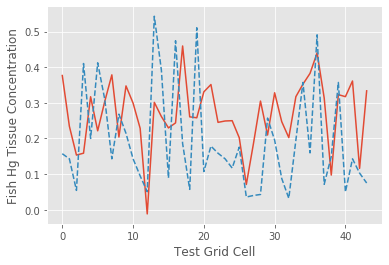

In [73]:
plt.plot(best_model.predict(X_test_norm))
plt.plot(y_test.values, '--');
plt.xlabel('Test Grid Cell')
plt.ylabel('Fish Hg Tissue Concentration')

# Compare with Statistical OLS Regression models

In [74]:
# Compare with OLS regression

#X=clean_df[['MO_ICP40','AL_ICP40', 'AS_AA', 'TI_ICP40']] 
X=clean_df[['AL_ICP40','CA_ICP40', 'FE_ICP40', 'TI_ICP40', 'SR_ICP40',
        'AS_AA', 'SE_AA']] 

# For each X, assess independent variables for multicolinearity
X.corr()

,AL_ICP40,CA_ICP40,FE_ICP40,TI_ICP40,SR_ICP40,AS_AA,SE_AA
AL_ICP40,1.000000,0.105773,0.742391,0.115026,0.736606,0.236462,0.079761
CA_ICP40,0.105773,1.000000,0.064647,-0.259561,0.379239,0.211274,0.227949
FE_ICP40,0.742391,0.064647,1.000000,0.431655,0.421571,0.247446,0.010555
TI_ICP40,0.115026,-0.259561,0.431655,1.000000,0.018363,-0.345852,-0.262499
SR_ICP40,0.736606,0.379239,0.421571,0.018363,1.000000,0.035092,0.080518
AS_AA,0.236462,0.211274,0.247446,-0.345852,0.035092,1.000000,0.464423
SE_AA,0.079761,0.227949,0.010555,-0.262499,0.080518,0.464423,1.000000


In [75]:
model = sm.OLS(y_train_val, X_train_val)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                hg_mean   R-squared (uncentered):                   0.327
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              9.092
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                    4.02e-09
Time:                        17:13:04   Log-Likelihood:                         -49.698
No. Observations:                 138   AIC:                                      113.4
Df Residuals:                     131   BIC:                                      133.9
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [76]:
# Compare with untransformed data

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                hg_mean   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.388
Method:                 Least Squares   F-statistic:                              20.66
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                    4.96e-21
Time:                        17:13:05   Log-Likelihood:                         -35.355
No. Observations:                 217   AIC:                                      84.71
Df Residuals:                     210   BIC:                                      108.4
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------